In [34]:
from pathlib import Path
import pandas as pd
import pickle

%matplotlib ipympl
import matplotlib.pyplot as plt
import numpy as np
import sys

sys.path.append("../")
from smpl2motorica.utils.bvh import BVHParser
from smpl2motorica.utils.pymo.preprocessing import MocapParameterizer
from IPython.display import display_html 

In [35]:
def get_SMPL_skeleton_names():
    return [
        # "pelvis",
        "left_hip",
        "right_hip",
        "spine1",
        "left_knee",
        "right_knee",
        "spine2",
        "left_ankle",
        "right_ankle",
        "spine3",
        "left_foot",
        "right_foot",
        "neck",
        "left_collar",
        "right_collar",
        "head",
        "left_shoulder",
        "right_shoulder",
        "left_elbow",
        "right_elbow",
        "left_wrist",
        "right_wrist",
    ]


# SMPL visualization
def SMPL_visulize_a_frame(fig, joints, vertices, model, output_name="test.png"):
    from matplotlib import pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    from mpl_toolkits.mplot3d.art3d import Poly3DCollection

    ax = fig.add_subplot(111, projection="3d")
    # ax.view_init(elev=0)
    mesh = Poly3DCollection(vertices[model.faces], alpha=0.01)
    face_color = (1.0, 1.0, 0.9)
    edge_color = (0, 0, 0)
    mesh.set_edgecolor(edge_color)
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)
    ax.scatter(joints[:, 0], joints[:, 1], joints[:, 2], color="r")
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])
    joint_names = get_SMPL_skeleton_names()
    for i, joint in enumerate(joints):
        ax.text(
            joint[0],
            joint[1],
            joint[2],
            f"{i}:{joint_names[i]}",
            color="blue",
            fontsize=5,
        )
    ax.view_init(elev=0, azim=180)
    return ax

## Motorica


In [36]:
# cwd
cwd = Path.cwd()
print(f"Current working directory: {cwd}")
# define some variables
motorica_data_root = Path("./data/motorica_dance_dataset")

motorica_motion_path = (
    motorica_data_root
    / "bvh"
    / "kthjazz_gCH_sFM_cAll_d02_mCH_ch01_beatlestreetwashboardbandfortyandtight_003.bvh"
)
if not motorica_motion_path.exists():
    raise FileNotFoundError(f"Motion file {motorica_motion_path} does not exist. ")

Current working directory: c:\Users\siyuan\research\smpl2motorica


In [37]:
def get_motorica_skeleton_names():
    return [
        "Head",
        "Hips",
        "LeftArm",
        "LeftFoot",
        "LeftForeArm",
        "LeftHand",
        "LeftLeg",
        "LeftShoulder",
        # "LeftToeBase",
        "LeftUpLeg",
        "Neck",
        "RightArm",
        "RightFoot",
        "RightForeArm",
        "RightHand",
        "RightLeg",
        "RightShoulder",
        # "RightToeBase",
        "RightUpLeg",
        "Spine",
        "Spine1",
    ]

def expand_motorica_skeleton(skeleton: list):
    expanded_skeleton = [f"{joint}_{axis}rotation" for joint in skeleton for axis in ['X', 'Y', 'Z']]
    return expanded_skeleton
    


def motorica_draw_stickfigure3d(
    fig,
    mocap_track,
    frame,
    data=None,
    joints=None,
    draw_names=True,
):
    from mpl_toolkits.mplot3d import Axes3D

    ax = fig.add_subplot(122, projection="3d")
    # ax.view_init(elev=0, azim=120)

    if joints is None:
        joints_to_draw = mocap_track.skeleton.keys()
    else:
        joints_to_draw = joints

    if data is None:
        df = mocap_track.values
    else:
        df = data

    for idx, joint in enumerate(joints_to_draw):
        parent_x = df["%s_Xposition" % joint][frame]
        parent_y = df["%s_Zposition" % joint][frame]
        parent_z = df["%s_Yposition" % joint][frame]
        # ^ In mocaps, Y is the up-right axis

        ax.scatter(xs=parent_x, ys=parent_y, zs=parent_z, alpha=0.6, c="b", marker="o")
        

        children_to_draw = [
            c for c in mocap_track.skeleton[joint]["children"] if c in joints_to_draw
        ]

        for c in children_to_draw:
            child_x = df["%s_Xposition" % c][frame]
            child_y = df["%s_Zposition" % c][frame]
            child_z = df["%s_Yposition" % c][frame]
            # ^ In mocaps, Y is the up-right axis

            ax.plot(
                [parent_x, child_x],
                [parent_y, child_y],
                [parent_z, child_z],
                # "k-",
                lw=2,
                c="black",
            )

        if draw_names:
            ax.text(
                x=parent_x - 0.5,
                y=parent_y - 0.5,
                z=parent_z - 0.5,
                s=f"{idx}:{joint}",
                fontsize=5,
            )

    return ax

In [38]:
# load the motion
bvh_parser = BVHParser()
motorica_dummy_data = bvh_parser.parse(motorica_motion_path)
motorica_dummy_df = motorica_dummy_data.values

# Filter out unnecessary columns
joints_to_keep = get_motorica_skeleton_names()
expand_joints_to_keep = expand_motorica_skeleton(joints_to_keep)
# append location to the joint names
expand_joint_with_location = ['Hips_Xposition', 'Hips_Yposition', 'Hips_Zposition'] + expand_joints_to_keep
# filter out unnecessary joints
motorica_dummy_df = motorica_dummy_df[expand_joint_with_location]

## SMPL


In [39]:
import smplx
import torch

amass_data_root = Path("./data/amass/Subject_1_F_1_stageii.npz")
smpl_model_path = Path("./smpl/models")
if not amass_data_root.exists():
    raise FileNotFoundError(f"AMASS data root {amass_data_root} does not exist. ")
if not smpl_model_path.is_dir():
    raise FileNotFoundError(f"SMPL model path {smpl_model_path} does not exist. ")


# load the data
data = np.load(amass_data_root, allow_pickle=True)
print(f"dataset fps: {data['mocap_frame_rate']}")
# sample every 10 frames
sample_indices = np.arange(0, data["poses"].shape[0], 10)
poses = data["poses"][sample_indices]
root_trans = data["trans"][sample_indices]
# setting root_trans to zero
# root_trans = np.zeros_like(root_trans)
# poses =  data["poses"][:2]
# root_trans = data["trans"][:2]
betas = data["betas"]
batch_size = poses.shape[0]
# batch the betas with batch size: (BxN_betas)
betas = np.tile(betas, (batch_size, 1))
num_beta = data["num_betas"]

dataset fps: 120.0


In [40]:
for key in data.keys():
    print(f"{key}: {data[key].shape}")

gender: ()
surface_model_type: ()
mocap_frame_rate: ()
mocap_time_length: ()
markers_latent: (67, 3)
latent_labels: (67,)
markers_latent_vids: ()
trans: (581, 3)
poses: (581, 165)
betas: (16,)
num_betas: ()
root_orient: (581, 3)
pose_body: (581, 63)
pose_hand: (581, 90)
pose_jaw: (581, 3)
pose_eye: (581, 6)


In [41]:
smpl_model = smplx.create(
    model_path=smpl_model_path,
    model_type="smplx",
    return_verts=True,
    num_betas = num_beta,
    betas = torch.tensor(betas, dtype=torch.float32),
    batch_size=len(poses)
)

# joints:
body_pose = poses[:, 3:66]
root_rot = poses[:, :3]
# body_pose = np.zeros_like(body_pose)
smpl_output = smpl_model(body_pose=torch.tensor(body_pose, dtype=torch.float32),
                        transl = torch.tensor(root_trans, dtype=torch.float32),
                        global_orient = torch.tensor(root_rot, dtype=torch.float32)
                         )
smpl_joints_loc = smpl_output.joints.detach().cpu().numpy().squeeze()
smpl_vertices = smpl_output.vertices.detach().cpu().numpy().squeeze()

## Visualization


In [42]:
frame_viz = 30

In [43]:
# SMPL joints: (# of frame, 63)
# reshape to (# of frame, 21, 3)
pose = body_pose.reshape(-1, 21, 3)
pose = pose[frame_viz]
joint_names = get_SMPL_skeleton_names()
smpl_df = pd.DataFrame(pose, columns=["rot x", "rot y", "rot z"], index=joint_names)

### For Converting SMPL to motorica

In [44]:
# make it all zero for now
motorica_debug_df = motorica_dummy_df.iloc[0]
# motorica_debug_df = motorica_debug_df * 0
# split the data. One with root position and one with all the other joints
motorica_root_pos = motorica_debug_df[["Hips_Xposition", "Hips_Yposition", "Hips_Zposition"]]
motorica_joints = motorica_debug_df.drop(["Hips_Xposition", "Hips_Yposition", "Hips_Zposition"])


In [45]:
joints_value = motorica_joints.values
joints_value = joints_value.reshape(len(joints_to_keep), 3)
new_col_name = ["rot x", "rot y", "rot z"]
new_index_name = joints_to_keep
motorica_joints_df = pd.DataFrame(joints_value, columns=new_col_name, index=new_index_name)


In [46]:
# reorder smpl joints to match motorica joints
smpl_in_motorica_order = [
    "head",
    "spine1",
    "left_shoulder",
    "left_ankle",
    "left_elbow",
    "left_wrist",
    "left_knee",
    "left_collar",
    "left_hip",
    "neck",
    "right_shoulder",
    "right_ankle",
    "right_elbow",
    "right_wrist",
    "right_knee",
    "right_collar",
    "right_hip",
    "spine2",
    "spine3",

    # "head",
    # "spine1",
    # "right_shoulder",
    # "right_ankle",
    # "right_elbow",
    # "right_wrist",
    # "right_knee",
    # "right_collar",
    # "right_hip",
    # "neck",
    # "left_shoulder",
    # "left_ankle",
    # "left_elbow",
    # "left_wrist",
    # "left_knee",
    # "left_collar",
    # "left_hip",
    # "spine2",
    # "spine3",
]

# Initial SMPL vs JOINT DF


In [47]:
# display two joints
smpl_df_styler = smpl_df.style.set_table_attributes("style='display:inline;vertical-align:top'").set_caption("SMPL joints")
motorica_df_syle = motorica_joints_df.style.set_table_attributes("style='display:inline;vertical-align:top'").set_caption("Motorica joints")
display_html(smpl_df_styler._repr_html_() + motorica_df_syle._repr_html_(), raw=True)

,rot x,rot y,rot z
left_hip,0.093162,0.034711,0.023365
right_hip,-0.513342,0.058536,-0.097617
spine1,0.188613,-0.050965,-0.102363
left_knee,0.393177,-0.360132,-0.021260
right_knee,0.017408,-0.049105,-0.005973
spine2,0.116151,0.015783,-0.069604
left_ankle,-0.141238,0.125151,0.106994
right_ankle,-0.010620,-0.309373,0.184386
spine3,0.037467,-0.009125,-0.063995
left_foot,-0.132112,0.240374,-0.085727


In [48]:
# Map SMPL joints to motorica joints and drop the rest
new_smpl_df = smpl_df.loc[smpl_in_motorica_order]
smpl_in_motorica_styler = new_smpl_df.style.set_table_attributes("style='display:inline;vertical-align:top'").set_caption("SMPL joints in motorica format")
display_html(smpl_in_motorica_styler._repr_html_() + motorica_df_syle._repr_html_(), raw=True)


,rot x,rot y,rot z
head,0.040823,-0.057128,0.071539
spine1,0.188613,-0.050965,-0.102363
left_shoulder,-0.175413,-0.380731,-0.262754
left_ankle,-0.141238,0.125151,0.106994
left_elbow,0.209072,-0.301336,0.050109
left_wrist,0.472821,0.027364,-0.084166
left_knee,0.393177,-0.360132,-0.021260
left_collar,-0.087731,-0.140712,-0.136016
left_hip,0.093162,0.034711,0.023365
neck,0.389112,0.043342,-0.015693


In [49]:
# Map SMPL joints to motorica joint
SMPL_joints_value = np.rad2deg(new_smpl_df.values)
# flatten
SMPL_joints_value.flatten()

array([  2.3389796 ,  -3.27321036,   4.09889041,  10.80672853,
        -2.92005543,  -5.8649747 , -10.05043962, -21.81430141,
       -15.0547214 ,  -8.09234644,   7.17064325,   6.13029717,
        11.97895576, -17.26527982,   2.87105654,  27.0906328 ,
         1.56786704,  -4.82234769,  22.52736073, -20.63401756,
        -1.21810262,  -5.02663442,  -8.06219744,  -7.79317117,
         5.33779741,   1.98881116,   1.33872977,  22.29447789,
         2.48330323,  -0.89917071,   7.38064652,  10.86643299,
        39.69875604,  -0.60849696, -17.72575949,  10.56453491,
         6.87529378,  38.34251987,  -6.70104554,  -1.04284116,
        -0.62467547,   5.75135872,   0.99741158,  -2.81349189,
        -0.34223252,  -0.60427417,   7.40179369,  10.55010279,
       -29.41230456,   3.35384467,  -5.59306258,   6.65494055,
         0.90428166,  -3.98799394,   2.14671804,  -0.52283539,
        -3.66663354])

In [50]:
motorica_joints = SMPL_joints_value.flatten()

In [51]:
# conconate the root position and the joints
root_pose = motorica_root_pos.values
# set root_pose to origin
root_pose = np.zeros_like(root_pose)
# motorica_joints = motorica_joints.values
debug_frame = np.concatenate([root_pose, motorica_joints], axis=0)
# put it back to dummy data
motorica_dummy_df.iloc[0] = debug_frame

C:\Users\siyuan\AppData\Local\Temp\ipykernel_56928\1163925916.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  motorica_dummy_df.iloc[0] = debug_frame


In [52]:

# #motorica visualization
motorica_dummy_data.values = pd.DataFrame(
            (motorica_dummy_df), columns=motorica_dummy_df.columns
        )
pose_df = MocapParameterizer("position").fit_transform([motorica_dummy_data])[0]
pose_df

In [53]:
pose_df.values

,Hips_Xposition,Hips_Yposition,Hips_Zposition,RightUpLeg_Xposition,RightUpLeg_Yposition,RightUpLeg_Zposition,RightLeg_Xposition,RightLeg_Yposition,RightLeg_Zposition,RightFoot_Xposition,...,LeftHandThumb3_Nub_Zposition,Neck_Xposition,Neck_Yposition,Neck_Zposition,Head_Xposition,Head_Yposition,Head_Zposition,Head_Nub_Xposition,Head_Nub_Yposition,Head_Nub_Zposition
0 days 00:00:00,0.00000,0.0000,0.0000,-9.416333,1.058363,-0.474746,-16.758351,-32.035352,10.773962,-25.085516,...,49.798812,9.883651,51.707083,16.783462,12.325775,61.026883,28.054333,12.325775,61.026883,28.054333
0 days 00:00:00.008333330,-18.25360,87.2029,-84.7195,-27.734855,87.086861,-84.395179,-28.134282,51.399563,-85.769901,-28.307801,...,-85.414948,-19.175575,142.312709,-87.193888,-19.777400,157.084149,-86.054789,-19.777400,157.084149,-86.054789
0 days 00:00:00.016666660,-18.25360,87.2029,-84.7195,-27.734907,87.085890,-84.397066,-28.134397,51.399231,-85.788256,-28.306187,...,-85.411987,-19.180509,142.312913,-87.187489,-19.780627,157.084796,-86.053240,-19.780627,157.084796,-86.053240
0 days 00:00:00.024999990,-18.25350,87.2029,-84.7195,-27.734861,87.084878,-84.399023,-28.133631,51.398388,-85.794743,-28.303012,...,-85.410311,-19.185576,142.313092,-87.181544,-19.783752,157.085443,-86.052379,-19.783752,157.085443,-86.052379
0 days 00:00:00.033333320,-18.25770,87.2029,-84.7195,-27.739114,87.083784,-84.400986,-28.136578,51.397037,-85.790520,-28.303346,...,-85.406167,-19.195249,142.313477,-87.171677,-19.791194,157.086241,-86.046741,-19.791194,157.086241,-86.046741
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0 days 00:02:51.291598150,-6.35997,87.2802,-100.2350,-15.842860,87.267815,-100.530785,-15.380510,51.615821,-102.617451,-14.943366,...,-99.723588,-6.376010,142.431361,-102.021727,-6.561034,157.216707,-100.919686,-6.561034,157.216707,-100.919686
0 days 00:02:51.299931480,-6.35997,87.2802,-100.2350,-15.842860,87.267815,-100.530785,-15.380510,51.615821,-102.617451,-14.943366,...,-99.723588,-6.376010,142.431361,-102.021727,-6.561034,157.216707,-100.919686,-6.561034,157.216707,-100.919686
0 days 00:02:51.308264810,-6.35997,87.2802,-100.2350,-15.842860,87.267815,-100.530785,-15.380510,51.615821,-102.617451,-14.943366,...,-99.723588,-6.376010,142.431361,-102.021727,-6.561034,157.216707,-100.919686,-6.561034,157.216707,-100.919686
0 days 00:02:51.316598140,-6.35997,87.2802,-100.2350,-15.842860,87.267815,-100.530785,-15.380510,51.615821,-102.617451,-14.943366,...,-99.723588,-6.376010,142.431361,-102.021727,-6.561034,157.216707,-100.919686,-6.561034,157.216707,-100.919686


In [54]:
# extract the SMPL 21 body joints
smpl_joints_loc = smpl_joints_loc[:, 1:22, :]

C:\Users\siyuan\AppData\Local\Temp\ipykernel_56928\2653724163.py:56: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  parent_x = df["%s_Xposition" % joint][frame]
C:\Users\siyuan\AppData\Local\Temp\ipykernel_56928\2653724163.py:57: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  parent_y = df["%s_Zposition" % joint][frame]
C:\Users\siyuan\AppData\Local\Temp\ipykernel_56928\2653724163.py:58: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p

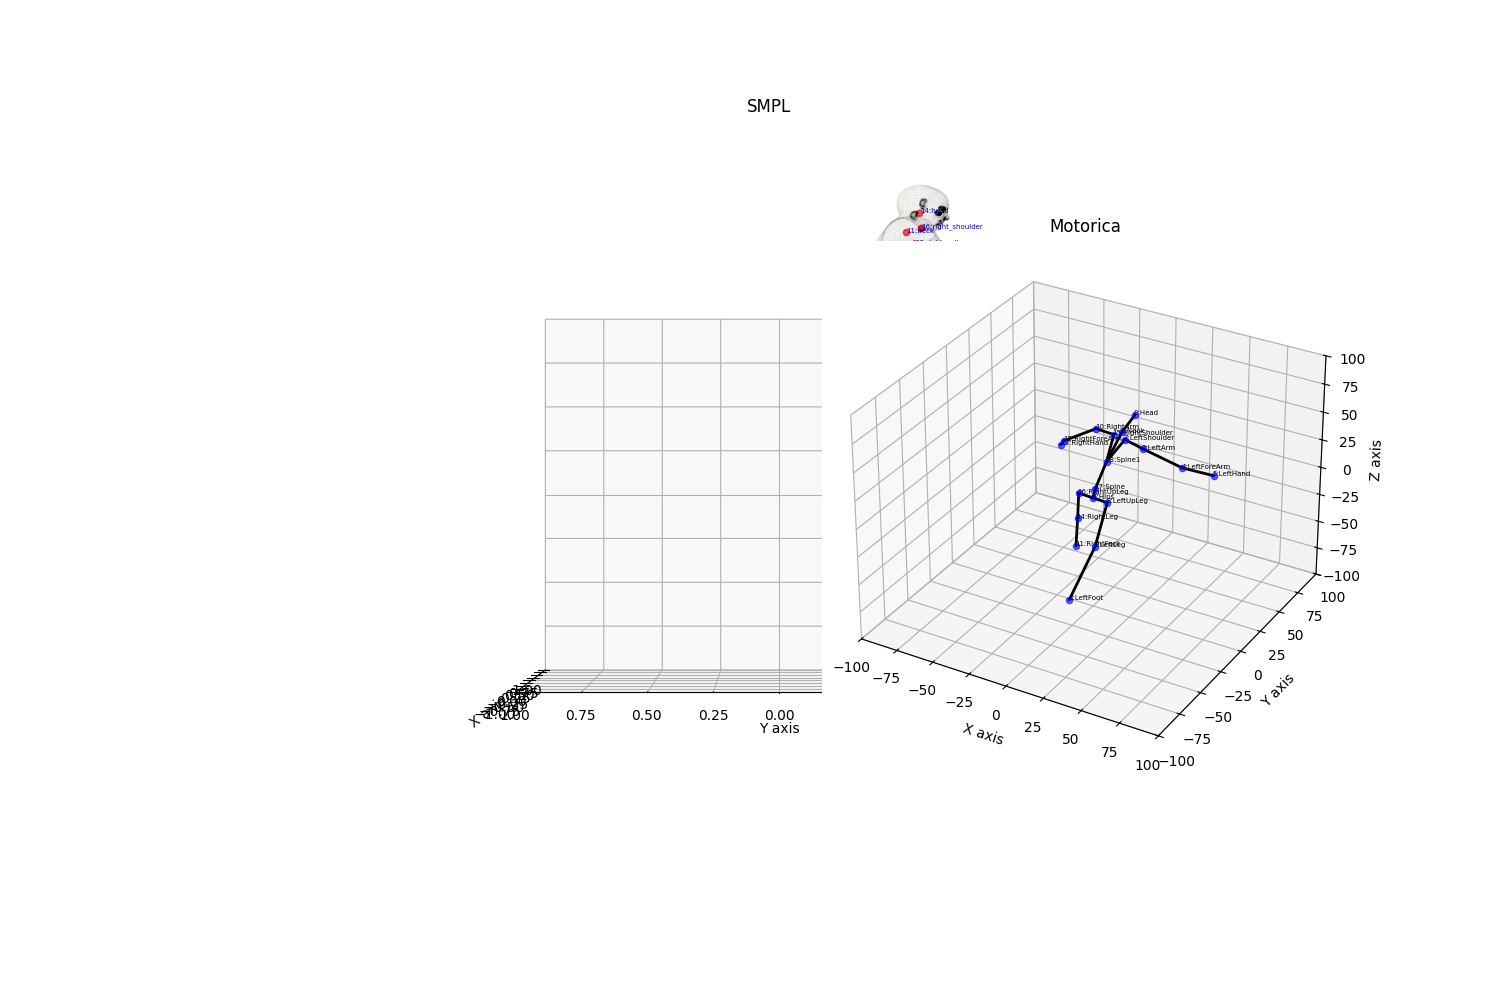

In [55]:
# ------------------
# visualize first frame
sample_smpl_joints = smpl_joints_loc[frame_viz]
sample_smpl_vertices = smpl_vertices[frame_viz]

fig = plt.figure(figsize=(15, 10))
smpl_ax = SMPL_visulize_a_frame(fig, sample_smpl_joints, sample_smpl_vertices, smpl_model)
motorica_ax = motorica_draw_stickfigure3d(
            fig=fig,
            mocap_track=pose_df, frame=0, joints=get_motorica_skeleton_names(), draw_names=True
        )

smpl_ax.set_title("SMPL")
smpl_ax.set_xlabel('X axis')
smpl_ax.set_ylabel('Y axis')
smpl_ax.set_zlabel('Z axis')
motorica_ax.set_title("Motorica")
motorica_ax.set_xlabel('X axis')
motorica_ax.set_ylabel('Y axis')
motorica_ax.set_zlabel('Z axis')
# motorica_ax.set_zlim([0, 200])
# motorica_ax.set_xlim([-100, 100])
# motorica_ax.set_ylim([-150, 50])

# for debugging
motorica_ax.set_zlim([-100, 100])
motorica_ax.set_xlim([-100, 100])
motorica_ax.set_ylim([-100, 100])

plt.show()


## SMPL Video Generation

In [56]:
# compile a video for the SMPL
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter
import cv2
import os
from tqdm import tqdm

def SMPL_output_video(joints, vertices, model):
    for i in tqdm(range(joints.shape[0]), desc="Generating SMPL video"):
        fig = plt.figure(figsize=(10, 10))
        ax = SMPL_visulize_a_frame(fig, joints[i], vertices[i], model)
        ax.set_title(f"SMPL frame {i}")
        plt.savefig(f"smpl_frame_{i:04d}.png")
        plt.close(fig)
    
    # compile the video
    image_folder = '.'
    video_name = 'smpl_video.mp4'
    images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
    frame = cv2.imread(os.path.join(image_folder, images[0]))
    height, width, layers = frame.shape

    fps = 12  # Set frames per second
    video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

    for image in images:
        video.write(cv2.imread(os.path.join(image_folder, image)))

    cv2.destroyAllWindows()
    video.release()
    # remove the images
    for image in images:
        os.remove(os.path.join(image_folder, image))
    
    return video_name
    

In [57]:
SMPL_output_video(smpl_joints_loc, smpl_vertices, smpl_model)

Generating SMPL video: 100%|██████████| 59/59 [00:23<00:00,  2.53it/s]


'smpl_video.mp4'